In [3]:
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import cudf
import cuml
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.model_selection import train_test_split
from scipy.stats import randint
import os
import pickle

In [4]:
retrain = False
num_classify = 30
classified_path = r'/mnt/c/users/attic/hls_kelp/imagery/rf_classified_cuML'
unclassified_path = r'/mnt/c/users/attic/hls_kelp/imagery/rf_prepped'
unclassified_files = os.listdir(unclassified_path)
reclassify = True #Reclassify previously classified images

In [3]:
if retrain:
    training_path = r'/mnt/c/users/attic/hls_kelp/imagery/rf_training_V2'
    training_files = os.listdir(training_path)
    training_data = []
    #file = 'HLS.L30.T11SKU.2018058T183349.v2.0_kelp_classified.tif'
    for file in training_files:
        with rasterio.open(os.path.join(training_path, file)) as src:
                training_img = src.read()  
        #print(training_img.shape)
        training_img = training_img[:,2600:3600,:]
        file_data = training_img.reshape(training_img.shape[0], -1) 
        training_data.append(file_data)

    combined_training_data = np.hstack(training_data)
    combined_training_data[6,:] = combined_training_data[6,:]

    df = cudf.DataFrame(combined_training_data.T)
    X = df.iloc[:, :-1].astype('float32')
    y = df.iloc[:, -1].astype('float32')
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)
    cu_rf_params = {
        'n_estimators':100,  # Increase number of trees
        'max_depth': 500,      # Increase maximum depth
        'n_bins': 50,         # Increase number of bins
        'n_streams': 20      # Adjust parallel streams based on GPU capability
    }

    cu_rf = cuRF()#**cu_rf_params)
    cu_rf.fit(X_train, y_train)
    y_pred = cu_rf.predict(X_test)

    accuracy = cuml.metrics.accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
else:
     print("Retrain set to False")

Retrain set to False


In [4]:
if retrain: 
    rf_path = r'/mnt/c/users/attic/hls_kelp/random_forest/'
    if not os.path.isdir(rf_path):
        os.mkdir(rf_path)
    with open(os.path.join(rf_path, 'cu_rf'), 'wb') as f:
        pickle.dump(cu_rf, f)

Original Image Shape: (13395600, 6)
Sum Shape: (13395600,)


/tmp/ipykernel_1136/2246029275.py:37: RuntimeWarning: divide by zero encountered in divide
  img_2D_normalized[:, i] = img_2D[:, i] / img_sum[:]  # Normalize each pixel by sum of band
/tmp/ipykernel_1136/2246029275.py:37: RuntimeWarning: invalid value encountered in divide
  img_2D_normalized[:, i] = img_2D[:, i] / img_sum[:]  # Normalize each pixel by sum of band
/tmp/ipykernel_1136/2246029275.py:40: RuntimeWarning: invalid value encountered in cast
  img_2D_normalized = (img_2D_normalized * 255).astype(np.uint8)


HLS.L30.T11SKU.2017119T183324.v2.0_rf_ready.tif


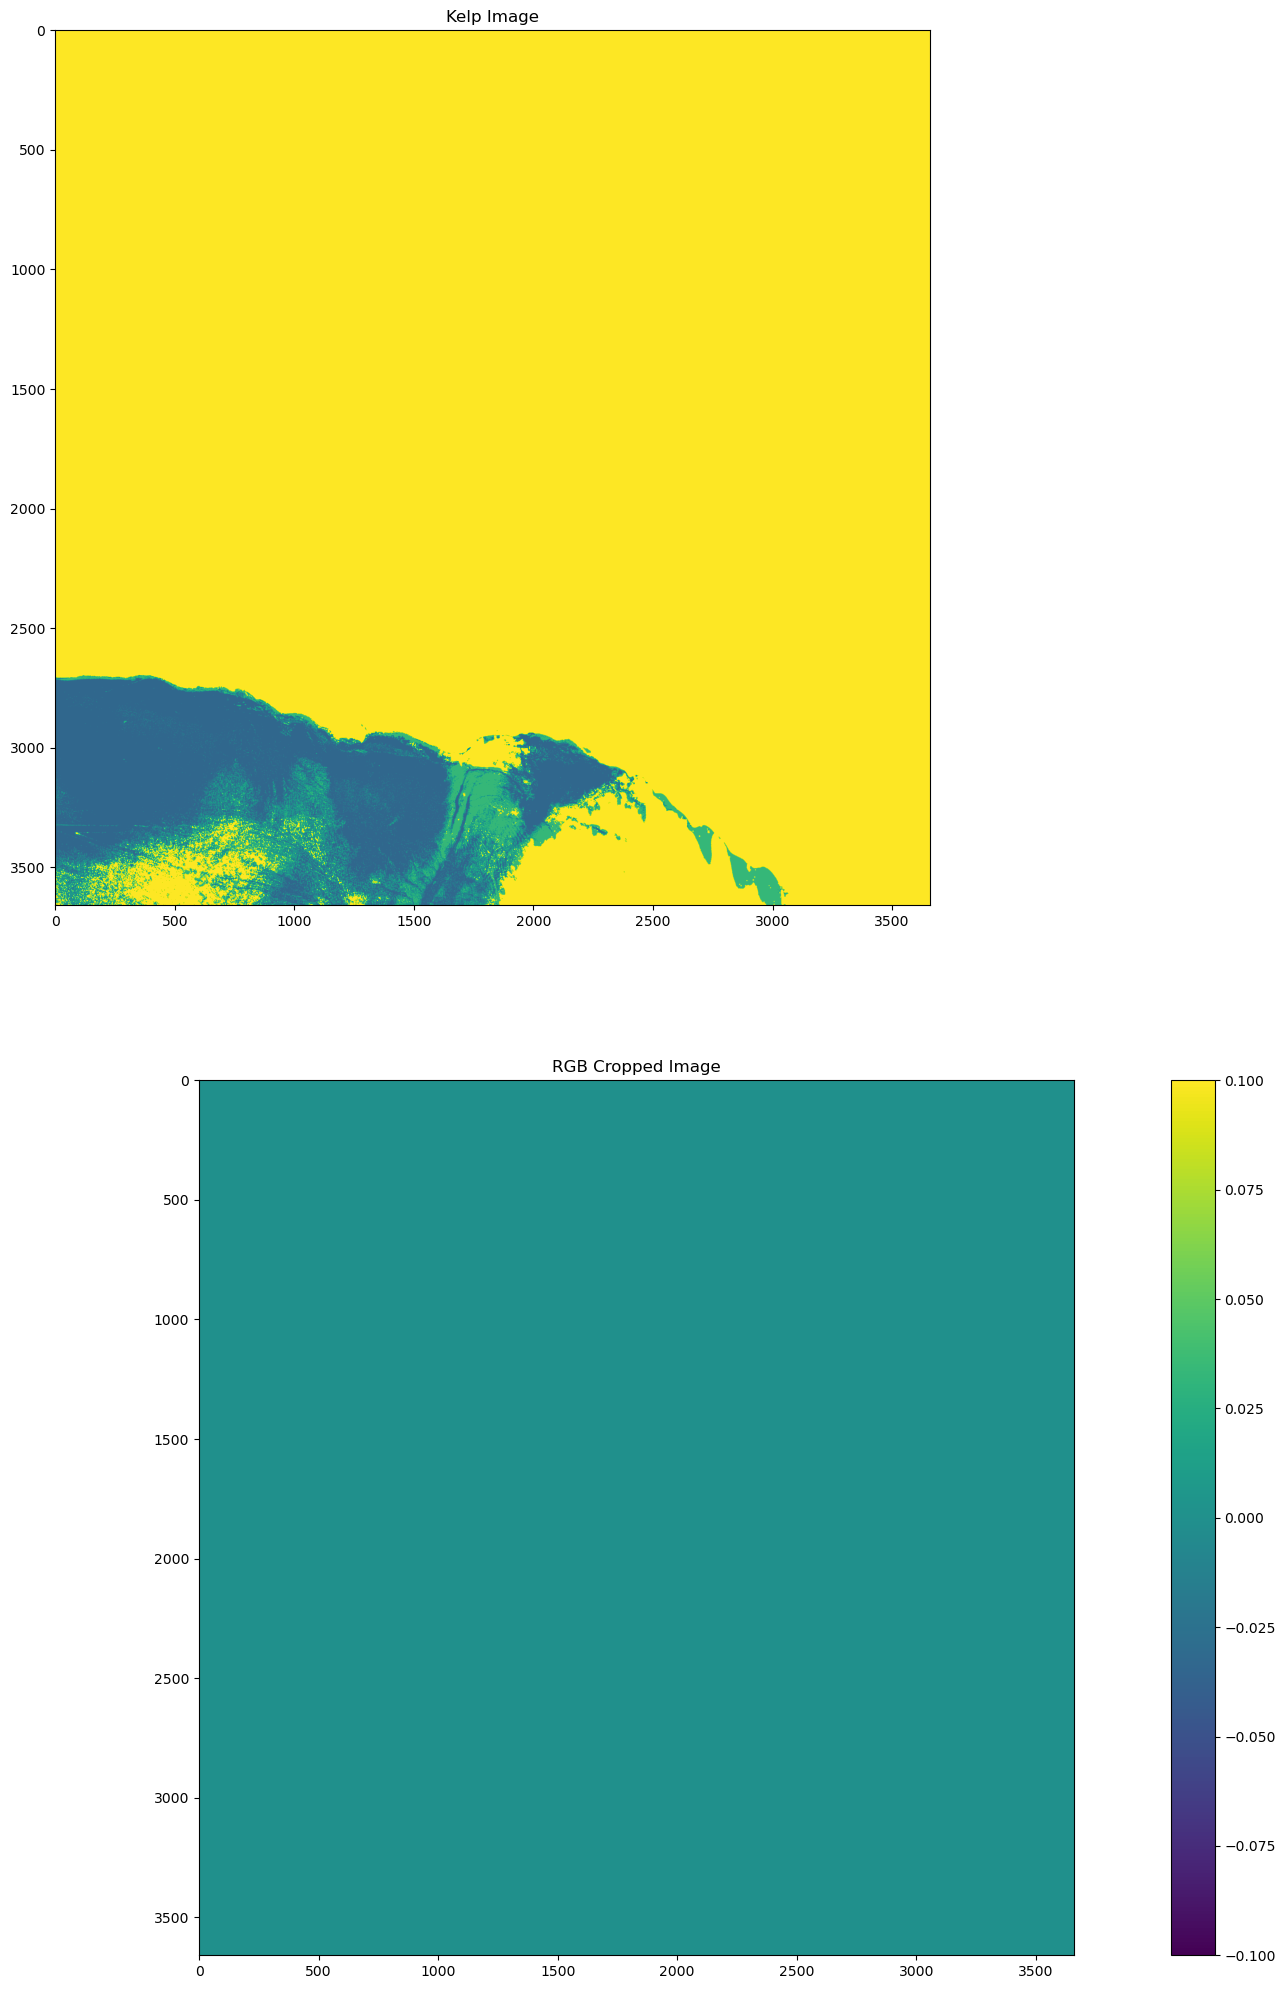

6 / 6


In [18]:
if not retrain:
    rf_path = r'/mnt/c/users/attic/hls_kelp/random_forest/cu_rf'
    with open(rf_path, 'rb') as f:
        cu_rf = pickle.load(f)

for i, file in enumerate(unclassified_files):
    if(i > num_classify):
         break
    if not reclassify and os.path.isfile(os.path.join(classified_path, f'{file}_kelp_classified.tif')):
        print(f"{file} already classified")
        continue
    file_img =[]
    with rasterio.open(os.path.join(unclassified_path,file)) as img:
        file_img.append(img.read(1))
        file_img.append(img.read(2))
        file_img.append(img.read(3))
        file_img.append(img.read(4))
        file_img.append(img.read(5))
        file_img.append(img.read(6))

        file_img = np.stack(file_img, axis=0)
        n_bands, height, width = file_img.shape
        img_2D = file_img.reshape(file_img.shape[0], -1).T 
        #print(img_2D)
         #classifier takes 2D array of band values for each pixel 
        #normalized_img_bands = np.column_stack((img_2D, cloud_mask_2D))
    ##========== Normalize multi-spectral data ==========##
        print(img_2D.shape)
        img_sum = img_2D.sum(axis=1)
        print(img_sum.shape)
        img_2D_normalized  = img_2D / img_sum[:,None] #divide value by sum of pixel band values
        print(img_2D_normalized.shape)
        img_2D_normalized = (img_2D_normalized * 255)
        img_2D_normalized = img_2D_normalized.astype(np.uint8)
        img_normalized = img_2D_normalized.reshape(file_img.shape)
    

        img_data= file_img.reshape(file_img.shape[0], -1).T
        img_data = cudf.DataFrame(img_data)
        print(file)
        kelp_pred = cu_rf.predict(img_data)
        
        kelp_img = kelp_pred.values_host.reshape(width,height)
        plt.figure(figsize=(25, 25)) 
        plt.subplot(2, 1, 1)  
        plt.imshow(kelp_img)#[2700:3400, 600:2000])
        plt.title("Kelp Image")
        #rgb = np.stack([file_img[2], file_img[1], file_img[0]], axis=-1)
        rgb = np.stack([img_normalized[2], img_normalized[1], img_normalized[0]], axis=-1)
        rgb_cropped = rgb#[2700:3400, 600:2000]
        plt.subplot(2, 1, 2) 
        plt.imshow(rgb)
        plt.title("RGB Cropped Image")
        plt.colorbar()
    
        plt.show()

        data_type = rasterio.uint8
        profile = {
            'driver': 'GTiff',
            'width': width,
            'height': height,
            'count': 5,  # one band  B02, B03, B04, and B05, classified (Blue, Green, Red, and NIR).
            'dtype': data_type,  # assuming binary mask, adjust dtype if needed
            'crs': img.crs,
            'transform': img.transform,
            'nodata': 0  # assuming no data is 0
        }
        # Write the land mask array to GeoTIFF
        with rasterio.open(os.path.join(classified_path, f'{file}_kelp_classified.tif'), 'w', **profile) as dst:
                dst.write(file_img[0].astype(data_type), 1)
                dst.write(file_img[1].astype(data_type), 2)
                dst.write(file_img[2].astype(data_type), 3)
                dst.write(file_img[3].astype(data_type), 4)
                dst.write(kelp_img.astype(data_type), 5)
        print(f'{i+1} / {len(unclassified_files)}')
        break